# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: LightGBM Tuning

***

**What is the objective of this file?**

To process the datasets to make it suitable for use in Model Training and Model Evaluation.

## Checklist

- Ensure that you have installed the necessary libraries needed to execute the training process. 
- You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 0. Preparations

In [79]:
#Python Libraries
import time, threading, math
from datetime import datetime

#Data/Dataset libraries
import pandas as pd
import numpy as np

#Split Sampler/Data Splitting
from sklearn.model_selection import train_test_split

#Oversampler
from imblearn.over_sampling import SMOTEN

#Label Encoding
# from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Timer
start = end = 0
LOG_FILENAME = "MalbehavD_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    global DATASET_FILENAME
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{DATASET_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

# 1. Import Datasets

**Notice:** 
1. Make sure check the value of line 3 of the block below before running.
2. A backup of the processed datasets is already found in `/Processed Datasets` folder. Simply unzip it to replace the contents of `/Processed Datasets/IB` and `/Processed Datasets/TB` folders.

In [80]:
#Filenames
filename = ["MalBD - RealWorld.csv"]
DATASET_FILENAME = filename[0] # <== CHANGE THIS ACCORDINGLY
API_LIST = "api_calls.txt"

#Load list of API calls
DELIMITER = "NaN"
API_FILE = open(API_LIST,"r")
APIS = API_FILE.readline().split(',')
APIS.append(DELIMITER) #serves as a label for NaN values for Instance-based datasets
API_FILE.close()

#Importing Datasets
oli = pd.read_csv(DATASET_FILENAME)
print("Oliveira Info:")
oli.info()

Oliveira Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Columns: 103 entries, hash to type
dtypes: int64(1), object(102)
memory usage: 103.9+ KB


In [81]:
APIS

['NtOpenThread',
 'ExitWindowsEx',
 'FindResourceW',
 'CryptExportKey',
 'CreateRemoteThreadEx',
 'MessageBoxTimeoutW',
 'InternetCrackUrlW',
 'StartServiceW',
 'GetFileSize',
 'GetVolumeNameForVolumeMountPointW',
 'GetFileInformationByHandle',
 'CryptAcquireContextW',
 'RtlDecompressBuffer',
 'SetWindowsHookExA',
 'RegSetValueExW',
 'LookupAccountSidW',
 'SetUnhandledExceptionFilter',
 'InternetConnectA',
 'GetComputerNameW',
 'RegEnumValueA',
 'NtOpenFile',
 'NtSaveKeyEx',
 'HttpOpenRequestA',
 'recv',
 'GetFileSizeEx',
 'LoadStringW',
 'SetInformationJobObject',
 'WSAConnect',
 'CryptDecrypt',
 'GetTimeZoneInformation',
 'InternetOpenW',
 'CoInitializeEx',
 'CryptGenKey',
 'GetAsyncKeyState',
 'NtQueryInformationFile',
 'GetSystemMetrics',
 'NtDeleteValueKey',
 'NtOpenKeyEx',
 'sendto',
 'IsDebuggerPresent',
 'RegQueryInfoKeyW',
 'NetShareEnum',
 'InternetOpenUrlW',
 'WSASocketA',
 'CopyFileExW',
 'connect',
 'ShellExecuteExW',
 'SearchPathW',
 'GetUserNameA',
 'InternetOpenUrlA',
 

In [82]:
#Previewing Dataset
oli.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware,type
0,981e9aa47cd71566d471cbb87c6287dbe51c637401596a...,NtOpenSection,GetForegroundWindow,WSARecv,GetFileVersionInfoSizeW,GetAdaptersAddresses,GetFileAttributesW,RegEnumKeyExA,RegOpenKeyExW,NtDelayExecution,...,CertOpenStore,NtOpenFile,RegQueryInfoKeyW,NtUnmapViewOfSection,NtQueryDirectoryFile,Module32NextW,NtQueryAttributesFile,NtCreateMutant,0,benign
1,ff35c0bed9b61b5fae1f28bec8acb10916a8605c95c778...,NtOpenSection,WSARecv,GetFileVersionInfoSizeW,GetAdaptersAddresses,GetFileAttributesW,RegOpenKeyExW,NtDelayExecution,SetErrorMode,GetFileInformationByHandle,...,CryptHashData,NtMapViewOfSection,NtFreeVirtualMemory,GetKeyState,CertOpenStore,OleInitialize,NtOpenFile,RegQueryInfoKeyW,0,benign
2,faf544452a8efd3d1cf2456ced8d9529e33f414ef1fca0...,LdrUnloadDll,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileAttributesW,RemoveDirectoryA,NtMapViewOfSection,GetSystemMetrics,...,SendNotifyMessageA,NtSetInformationFile,GetComputerNameW,GetComputerNameA,FindFirstFileExW,NtOpenMutant,RegDeleteKeyA,GetNativeSystemInfo,0,benign
3,e3495f53563d473aeec5c7a03ec5bbe32cc7ff278352fe...,NtOpenSection,GetForegroundWindow,RegEnumKeyW,GetFileVersionInfoSizeW,GetFileAttributesW,GetVolumePathNamesForVolumeNameW,RegOpenKeyExW,SetErrorMode,ShellExecuteExW,...,NtQueryDirectoryFile,NtQueryAttributesFile,NtCreateMutant,NtOpenKey,OpenSCManagerW,FindResourceW,GetFileVersionInfoW,IsDebuggerPresent,0,benign
4,7ef3316642fa9506ccb7df599aa5b107ad45929bf45abc...,LdrUnloadDll,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileAttributesW,RemoveDirectoryA,NtMapViewOfSection,GetSystemMetrics,...,OleInitialize,NtOpenFile,NtQueryDirectoryFile,NtCreateMutant,FindResourceW,GetFileVersionInfoW,GetUserNameExW,GetFileAttributesExW,0,benign


In [83]:
print("Oliveira Label Counts")
print("0 as Benign, 1 as Malicious")
oli.malware.value_counts()

Oliveira Label Counts
0 as Benign, 1 as Malicious


malware
0    85
1    44
Name: count, dtype: int64

Oliveira Unique API calls list


<Axes: title={'center': "Top 20 API calls in 'Oliveira'"}>

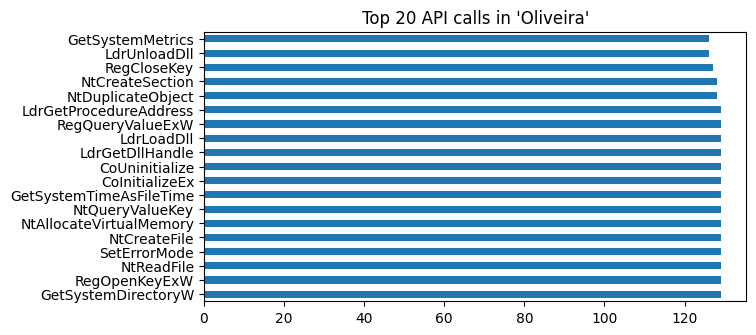

In [84]:
print("Oliveira Unique API calls list")
oli_unique = pd.Series(oli[list(oli.columns.values)[1:101]].values.ravel())
oli_unique.sort_values(inplace=True, ascending=False)
oli_unique.value_counts()[0:19].plot(kind='barh', figsize=(7,3.5), title='Top 20 API calls in \'Oliveira\'') #Top 20 only

In [85]:
oli_unique.unique()

array(['timeGetTime', 'socket', 'shutdown', 'setsockopt', 'send',
       'select', 'recv', 'listen', 'ioctlsocket', 'getsockname',
       'gethostbyname', 'getaddrinfo', 'connect', 'closesocket', 'bind',
       'accept', '__exception__', 'WriteProcessMemory', 'WriteConsoleW',
       'WriteConsoleA', 'WSAStartup', 'WSASocketW', 'WSASocketA',
       'WSASend', 'WSARecv', 'WSAConnect', 'UuidCreate',
       'UnhookWindowsHookEx', 'URLDownloadToFileW', 'Thread32Next',
       'Thread32First', 'StartServiceW', 'StartServiceA',
       'SizeofResource', 'ShellExecuteExW', 'SetWindowsHookExW',
       'SetWindowsHookExA', 'SetUnhandledExceptionFilter', 'SetStdHandle',
       'SetInformationJobObject', 'SetFileTime', 'SetFilePointerEx',
       'SetFilePointer', 'SetFileInformationByHandle',
       'SetFileAttributesW', 'SetErrorMode', 'SetEndOfFile',
       'SendNotifyMessageW', 'SendNotifyMessageA', 'SearchPathW',
       'SHGetSpecialFolderLocation', 'SHGetFolderPathW',
       'RtlRemoveVectoredE

# 2. Dataset Preparation

## 2.1. Dataset Cleaning and Dataset Formatting

In [86]:
# Remove falsely labelled malicious samples
oli = oli[oli['type'] != '_']

# Remove specific malware types
# removables = ['ransomware', 'miner', 'virus', 'spyware', 'hacktool', 'dropper', 'worm']
# for r in removables:
#     oli = oli[oli['type'] != r]

#Remove type column
type_col = oli.pop('type')

#Removing hash column
hash_col = oli.pop('hash')

#Re-arranging column positions
label_col = oli.pop('malware')
oli = pd.concat([label_col, oli], axis=1)
oli = pd.concat([oli, hash_col], axis=1) # <=== This will be retained for the benefit of model evaluation.
oli = pd.concat([oli, type_col], axis=1) # <=== This will be retained for the benefit of model evaluation.

oli

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,0,NtOpenSection,GetForegroundWindow,WSARecv,GetFileVersionInfoSizeW,GetAdaptersAddresses,GetFileAttributesW,RegEnumKeyExA,RegOpenKeyExW,NtDelayExecution,...,CertOpenStore,NtOpenFile,RegQueryInfoKeyW,NtUnmapViewOfSection,NtQueryDirectoryFile,Module32NextW,NtQueryAttributesFile,NtCreateMutant,981e9aa47cd71566d471cbb87c6287dbe51c637401596a...,benign
1,0,NtOpenSection,WSARecv,GetFileVersionInfoSizeW,GetAdaptersAddresses,GetFileAttributesW,RegOpenKeyExW,NtDelayExecution,SetErrorMode,GetFileInformationByHandle,...,CryptHashData,NtMapViewOfSection,NtFreeVirtualMemory,GetKeyState,CertOpenStore,OleInitialize,NtOpenFile,RegQueryInfoKeyW,ff35c0bed9b61b5fae1f28bec8acb10916a8605c95c778...,benign
2,0,LdrUnloadDll,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileAttributesW,RemoveDirectoryA,NtMapViewOfSection,GetSystemMetrics,...,SendNotifyMessageA,NtSetInformationFile,GetComputerNameW,GetComputerNameA,FindFirstFileExW,NtOpenMutant,RegDeleteKeyA,GetNativeSystemInfo,faf544452a8efd3d1cf2456ced8d9529e33f414ef1fca0...,benign
3,0,NtOpenSection,GetForegroundWindow,RegEnumKeyW,GetFileVersionInfoSizeW,GetFileAttributesW,GetVolumePathNamesForVolumeNameW,RegOpenKeyExW,SetErrorMode,ShellExecuteExW,...,NtQueryDirectoryFile,NtQueryAttributesFile,NtCreateMutant,NtOpenKey,OpenSCManagerW,FindResourceW,GetFileVersionInfoW,IsDebuggerPresent,e3495f53563d473aeec5c7a03ec5bbe32cc7ff278352fe...,benign
4,0,LdrUnloadDll,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileAttributesW,RemoveDirectoryA,NtMapViewOfSection,GetSystemMetrics,...,OleInitialize,NtOpenFile,NtQueryDirectoryFile,NtCreateMutant,FindResourceW,GetFileVersionInfoW,GetUserNameExW,GetFileAttributesExW,7ef3316642fa9506ccb7df599aa5b107ad45929bf45abc...,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,1,GetUserNameExW,NtOpenSection,GetForegroundWindow,WSARecv,RegEnumKeyW,GetUserNameExA,GetFileVersionInfoSizeW,GetAdaptersAddresses,GetFileAttributesW,...,RegEnumKeyExA,closesocket,RegEnumValueW,NtCreateSection,GetKeyboardState,RegSetValueExW,RegEnumValueA,InternetOpenW,ef1c69dfe182587ff715be5bdcc2be90ed6ef81fa56b8e...,virus
125,1,GetUserNameExW,NtOpenSection,GetForegroundWindow,NtSetValueKey,CreateJobObjectW,GetUserNameExA,GetAdaptersAddresses,GetFileAttributesW,SetInformationJobObject,...,NtFreeVirtualMemory,GetKeyState,OleInitialize,NtOpenFile,RegQueryInfoKeyW,SetFilePointer,NtUnmapViewOfSection,__exception__,ee029f7c10d1da187bfd82d7852460ba7808060e855b9c...,virus
126,1,GetUserNameExW,NtOpenSection,NtSetValueKey,WSARecv,GetAdaptersAddresses,GetFileAttributesW,RegEnumKeyExA,RegOpenKeyExW,NtDelayExecution,...,RegEnumValueA,GetFileType,WSASocketW,RegDeleteKeyA,NtDuplicateObject,getsockname,OpenSCManagerW,GetSystemInfo,ee25bc47914cfb5064288f65c9ec5fec94853ac8b871e2...,trojan
127,1,GetUserNameExW,GetNativeSystemInfo,NtOpenSection,CoUninitialize,RegCloseKey,NtDuplicateObject,GetSystemInfo,WSAStartup,NtQueryDirectoryFile,...,CryptAcquireContextW,MessageBoxTimeoutW,GlobalMemoryStatus,GetSystemDirectoryA,closesocket,GlobalMemoryStatusEx,RegEnumValueW,InternetOpenW,ede1428f8e6ec8fcf886b3cbfcca9094f26bdc96cc9c1b...,trojan


## 2.2. Inverse Data Encoding

*Encoded (Ordinal) API calls to String API Calls*

In [87]:
def convert(api:str):
    return APIS.index(api)

for j in range(1,101):
    oli.iloc[:,j] = pd.Series(list(map(convert, oli.iloc[:,j].to_list())))

oli

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,0,106,266,216,293,121,194,113,260,159,...,217,20,40,178,114,244,298,86,981e9aa47cd71566d471cbb87c6287dbe51c637401596a...,benign
1,0,106,216,293,121,194,260,159,286,10,...,301,171,187,174,217,110,20,40,ff35c0bed9b61b5fae1f28bec8acb10916a8605c95c778...,benign
2,0,50,198,39,71,215,194,131,171,35,...,227,119,18,185,257,156,289,99,faf544452a8efd3d1cf2456ced8d9529e33f414ef1fca0...,benign
3,0,106,266,202,293,194,162,260,286,46,...,114,298,86,274,91,2,256,39,e3495f53563d473aeec5c7a03ec5bbe32cc7ff278352fe...,benign
4,0,50,198,39,71,215,194,131,171,35,...,110,20,114,86,2,256,139,73,7ef3316642fa9506ccb7df599aa5b107ad45929bf45abc...,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,1,139,106,266,216,202,184,293,121,194,...,113,148,226,135,130,14,19,30,ef1c69dfe182587ff715be5bdcc2be90ed6ef81fa56b8e...,virus
125,1,139,106,266,284,180,184,121,194,26,...,187,174,110,20,40,199,178,306,ee029f7c10d1da187bfd82d7852460ba7808060e855b9c...,virus
126,1,139,106,284,216,121,194,113,260,159,...,19,93,231,289,89,75,91,198,ee25bc47914cfb5064288f65c9ec5fec94853ac8b871e2...,trojan
127,1,139,99,106,214,65,89,198,108,114,...,11,5,118,85,148,72,226,30,ede1428f8e6ec8fcf886b3cbfcca9094f26bdc96cc9c1b...,trojan


In [88]:
#Inverse Label Encoding
def inverse_label(item):
    global APIS
    return item.map(lambda x: APIS[int(x)])
start_time()
oli.iloc[:, 1:101] = oli.iloc[:, 1:101].apply(inverse_label, axis=1, result_type='reduce')
end_time("Inverse Data Encode")

oli.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,0,NtOpenSection,GetForegroundWindow,WSARecv,GetFileVersionInfoSizeW,GetAdaptersAddresses,GetFileAttributesW,RegEnumKeyExA,RegOpenKeyExW,NtDelayExecution,...,CertOpenStore,NtOpenFile,RegQueryInfoKeyW,NtUnmapViewOfSection,NtQueryDirectoryFile,Module32NextW,NtQueryAttributesFile,NtCreateMutant,981e9aa47cd71566d471cbb87c6287dbe51c637401596a...,benign
1,0,NtOpenSection,WSARecv,GetFileVersionInfoSizeW,GetAdaptersAddresses,GetFileAttributesW,RegOpenKeyExW,NtDelayExecution,SetErrorMode,GetFileInformationByHandle,...,CryptHashData,NtMapViewOfSection,NtFreeVirtualMemory,GetKeyState,CertOpenStore,OleInitialize,NtOpenFile,RegQueryInfoKeyW,ff35c0bed9b61b5fae1f28bec8acb10916a8605c95c778...,benign
2,0,LdrUnloadDll,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileAttributesW,RemoveDirectoryA,NtMapViewOfSection,GetSystemMetrics,...,SendNotifyMessageA,NtSetInformationFile,GetComputerNameW,GetComputerNameA,FindFirstFileExW,NtOpenMutant,RegDeleteKeyA,GetNativeSystemInfo,faf544452a8efd3d1cf2456ced8d9529e33f414ef1fca0...,benign
3,0,NtOpenSection,GetForegroundWindow,RegEnumKeyW,GetFileVersionInfoSizeW,GetFileAttributesW,GetVolumePathNamesForVolumeNameW,RegOpenKeyExW,SetErrorMode,ShellExecuteExW,...,NtQueryDirectoryFile,NtQueryAttributesFile,NtCreateMutant,NtOpenKey,OpenSCManagerW,FindResourceW,GetFileVersionInfoW,IsDebuggerPresent,e3495f53563d473aeec5c7a03ec5bbe32cc7ff278352fe...,benign
4,0,LdrUnloadDll,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileAttributesW,RemoveDirectoryA,NtMapViewOfSection,GetSystemMetrics,...,OleInitialize,NtOpenFile,NtQueryDirectoryFile,NtCreateMutant,FindResourceW,GetFileVersionInfoW,GetUserNameExW,GetFileAttributesExW,7ef3316642fa9506ccb7df599aa5b107ad45929bf45abc...,benign


Oliveira Unique API calls list


<Axes: title={'center': "Top 20 API calls in 'Oliveira'"}>

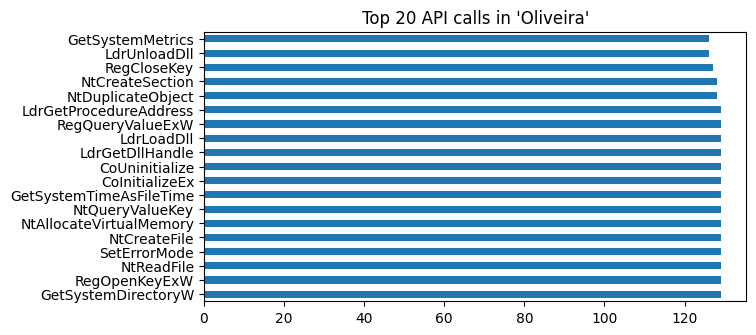

In [89]:
print("Oliveira Unique API calls list")
oli_unique = pd.Series(oli[list(oli.columns.values)[1:101]].values.ravel())
oli_unique.sort_values(inplace=True, ascending=False)
oli_unique.value_counts()[0:19].plot(kind='barh', figsize=(7,3.5), title='Top 20 API calls in \'Oliveira\'') #Top 20 only

In [90]:
oli_unique.unique()

array(['timeGetTime', 'socket', 'shutdown', 'setsockopt', 'send',
       'select', 'recv', 'listen', 'ioctlsocket', 'getsockname',
       'gethostbyname', 'getaddrinfo', 'connect', 'closesocket', 'bind',
       'accept', '__exception__', 'WriteProcessMemory', 'WriteConsoleW',
       'WriteConsoleA', 'WSAStartup', 'WSASocketW', 'WSASocketA',
       'WSASend', 'WSARecv', 'WSAConnect', 'UuidCreate',
       'UnhookWindowsHookEx', 'URLDownloadToFileW', 'Thread32Next',
       'Thread32First', 'StartServiceW', 'StartServiceA',
       'SizeofResource', 'ShellExecuteExW', 'SetWindowsHookExW',
       'SetWindowsHookExA', 'SetUnhandledExceptionFilter', 'SetStdHandle',
       'SetInformationJobObject', 'SetFileTime', 'SetFilePointerEx',
       'SetFilePointer', 'SetFileInformationByHandle',
       'SetFileAttributesW', 'SetErrorMode', 'SetEndOfFile',
       'SendNotifyMessageW', 'SendNotifyMessageA', 'SearchPathW',
       'SHGetSpecialFolderLocation', 'SHGetFolderPathW',
       'RtlRemoveVectoredE

## 2.3. Feature Duplicate Processing

*Building Time-based and Instance-Based Datasets*

In [91]:
TB = oli.copy(deep=True) #Time-based behavior (same as original)
IB = oli.copy(deep=True) #Instance-based behavior (to be created)

start_time()
print("Transposing IB...")
IB.transpose()
print("IB Transposed!")
print("Removing duplicates...")
print("Row:", end=" ")
for r in range(oli.shape[0]):
    #Per row (sample) removal of duplicates, thus cannot scale into the whole dataframe (which is way faster)
    row = IB.iloc[r, 1:101].drop_duplicates(keep='first', inplace=False).to_list()
    IB.iloc[r, 1:101] = row + ([DELIMITER]*(100-len(row)))
    if r % 100 == 0:
        print(r, end=" ")
print("\nDuplicates removed!")
print("Retransposing IB (revert)...")
IB.transpose()
print("IB Retransposed!")
end_time("Feature Duplicate Process")

Transposing IB...
IB Transposed!
Removing duplicates...
Row: 0 100 
Duplicates removed!
Retransposing IB (revert)...
IB Retransposed!


1.021586

In [92]:
IB

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,0,NtOpenSection,GetForegroundWindow,WSARecv,GetFileVersionInfoSizeW,GetAdaptersAddresses,GetFileAttributesW,RegEnumKeyExA,RegOpenKeyExW,NtDelayExecution,...,CertOpenStore,NtOpenFile,RegQueryInfoKeyW,NtUnmapViewOfSection,NtQueryDirectoryFile,Module32NextW,NtQueryAttributesFile,NtCreateMutant,981e9aa47cd71566d471cbb87c6287dbe51c637401596a...,benign
1,0,NtOpenSection,WSARecv,GetFileVersionInfoSizeW,GetAdaptersAddresses,GetFileAttributesW,RegOpenKeyExW,NtDelayExecution,SetErrorMode,GetFileInformationByHandle,...,CryptHashData,NtMapViewOfSection,NtFreeVirtualMemory,GetKeyState,CertOpenStore,OleInitialize,NtOpenFile,RegQueryInfoKeyW,ff35c0bed9b61b5fae1f28bec8acb10916a8605c95c778...,benign
2,0,LdrUnloadDll,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileAttributesW,RemoveDirectoryA,NtMapViewOfSection,GetSystemMetrics,...,SendNotifyMessageA,NtSetInformationFile,GetComputerNameW,GetComputerNameA,FindFirstFileExW,NtOpenMutant,RegDeleteKeyA,GetNativeSystemInfo,faf544452a8efd3d1cf2456ced8d9529e33f414ef1fca0...,benign
3,0,NtOpenSection,GetForegroundWindow,RegEnumKeyW,GetFileVersionInfoSizeW,GetFileAttributesW,GetVolumePathNamesForVolumeNameW,RegOpenKeyExW,SetErrorMode,ShellExecuteExW,...,NtQueryDirectoryFile,NtQueryAttributesFile,NtCreateMutant,NtOpenKey,OpenSCManagerW,FindResourceW,GetFileVersionInfoW,IsDebuggerPresent,e3495f53563d473aeec5c7a03ec5bbe32cc7ff278352fe...,benign
4,0,LdrUnloadDll,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileAttributesW,RemoveDirectoryA,NtMapViewOfSection,GetSystemMetrics,...,OleInitialize,NtOpenFile,NtQueryDirectoryFile,NtCreateMutant,FindResourceW,GetFileVersionInfoW,GetUserNameExW,GetFileAttributesExW,7ef3316642fa9506ccb7df599aa5b107ad45929bf45abc...,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,1,GetUserNameExW,NtOpenSection,GetForegroundWindow,WSARecv,RegEnumKeyW,GetUserNameExA,GetFileVersionInfoSizeW,GetAdaptersAddresses,GetFileAttributesW,...,RegEnumKeyExA,closesocket,RegEnumValueW,NtCreateSection,GetKeyboardState,RegSetValueExW,RegEnumValueA,InternetOpenW,ef1c69dfe182587ff715be5bdcc2be90ed6ef81fa56b8e...,virus
125,1,GetUserNameExW,NtOpenSection,GetForegroundWindow,NtSetValueKey,CreateJobObjectW,GetUserNameExA,GetAdaptersAddresses,GetFileAttributesW,SetInformationJobObject,...,NtFreeVirtualMemory,GetKeyState,OleInitialize,NtOpenFile,RegQueryInfoKeyW,SetFilePointer,NtUnmapViewOfSection,__exception__,ee029f7c10d1da187bfd82d7852460ba7808060e855b9c...,virus
126,1,GetUserNameExW,NtOpenSection,NtSetValueKey,WSARecv,GetAdaptersAddresses,GetFileAttributesW,RegEnumKeyExA,RegOpenKeyExW,NtDelayExecution,...,RegEnumValueA,GetFileType,WSASocketW,RegDeleteKeyA,NtDuplicateObject,getsockname,OpenSCManagerW,GetSystemInfo,ee25bc47914cfb5064288f65c9ec5fec94853ac8b871e2...,trojan
127,1,GetUserNameExW,GetNativeSystemInfo,NtOpenSection,CoUninitialize,RegCloseKey,NtDuplicateObject,GetSystemInfo,WSAStartup,NtQueryDirectoryFile,...,CryptAcquireContextW,MessageBoxTimeoutW,GlobalMemoryStatus,GetSystemDirectoryA,closesocket,GlobalMemoryStatusEx,RegEnumValueW,InternetOpenW,ede1428f8e6ec8fcf886b3cbfcca9094f26bdc96cc9c1b...,trojan


# 5. (Manual) Ordinal Encoding

In [93]:
def convert(api:str):
    return APIS.index(api)
def ordinal_encode(offset):
    global APIS
    global ENCODED
    for j in range(1,101):
        ENCODED[offset].iloc[:,j] = pd.Series(list(map(convert, ENCODED[offset].iloc[:,j].to_list())))

ENCODED = [TB.copy(deep=True), IB.copy(deep=True)]

tb_thread = threading.Thread(target=ordinal_encode, args=(0,))
ib_thread = threading.Thread(target=ordinal_encode, args=(1,))

start_time()
tb_thread.start()
ib_thread.start()
tb_thread.join()
ib_thread.join()
end_time("Label Encode")

0.267398

# 6. Saving to File

In [94]:
def save_to_csv(dfs, filenames):
    for d in range(len(dfs)):
        dfs[d].to_csv(index=False, chunksize=100, mode='w', path_or_buf=filenames[d])

STR_FILENAMES = ['TB/M-CATB_TB.csv', 'IB/M-CATB_IB.csv', 'TB/M-CATB_TB_Test.csv', 'IB/M-CATB_IB_Test.csv']
STR_API = [TB.copy(deep=True), IB.copy(deep=True)]

ENC_FILENAMES = ['TB/M-LGBM_TB.csv', 'IB/M-LGBM_IB.csv', 'TB/M-LGBM_TB_Test.csv', 'IB/M-LGBM_IB_Test.csv']
ENC_API = ENCODED

start_time()
save_to_csv(STR_API, STR_FILENAMES)
save_to_csv(ENC_API, ENC_FILENAMES)
end_time('save_to_file')

0.045341

In [95]:
logging("\n") #Adds a spacer for next instance of logs for this.